In [1]:
from qiskit import *
import numpy as np
from quantum_permutation_utils import *

## **Task 2 : Missing Number**

Here we will be given a list of numbers where the elements of that list will be numbers that can range from $0$ to $2^n$ for some integer 'n' in any arbitrary manner. However one particular element from the list will be missing and our aim is to find that one !

### **Method : Quantum Approach**

First I will explain how we can solve this problem on a quantum computer and I will approach the problem in the manner suggested in the problem description. My implementation will have the follwoing steps, first we use a QRAM like data loading process to encode the provided data into an phase oracle, next we implement a grover type search which will selectively amplify the required missing number for us ! 

#### **Algorithm**



**Step 1:** Prepare an equal superpoition of all $2^n$ basis states in the `data-register` and $\ket{-}$ state in the `ancilla` register.
$$                  \sum_{x \in \{1,0\}^{n}}\ket{x}  \otimes  \ket{-}
$$
**Step 2:** Apply a oracle operator to the `data-register` such that every basis state $\ket{x}$ other than the missing state $\ket{m}$ acquires a $(-1)$ phase, relatively speaking the $\ket{m}$ will acquire a $(-1)$ phase.
$$                \left(  \sum_{x \in \{1,0\}^{n} / m}\ket{x} - \ket{m} \right) \otimes  \ket{-}
$$
**Step 3:** Apply a diffuser operator that reflects the state about the intial equal superposition state. This step and the previous one essentially completes a grover operation whihc slecctively ampliifes the the missing state $\ket{m}$, thus increasing the probablity of measuring it.

#### **Example**

Here we are tyring the case of $4$ qubits, for demonstration we will randomly pop one element out if it!

In [9]:
num = 4
l = list(range(2**4))
l.pop(np.random.randint(0,16)), l

(9, [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15])

In [10]:
input_list = l
num_bits = int(np.ceil(np.log2(len(input_list))))
input_list_bin = [ format(elem, 'b').zfill(num_bits) for elem in input_list ]

In [11]:
## initiate circuit ##

qreg = QuantumRegister(num_bits, name= 'data-register')
ancilla_2 = QuantumRegister(1, name= 'ancilla')
qc = QuantumCircuit(qreg, ancilla_2)

qc.h(qreg)
qc.x(ancilla_2)
qc.h(ancilla_2)
qc.barrier()

## append grover operations ##

num_grover_steps = 1
for _ in range(num_grover_steps):
    
    ## append oracle ##
    for bin_str in input_list_bin:
        # bin_str = bin_str[::-1]
        for index, bit in enumerate(bin_str):
            if bit == '0': qc.x(qreg[index])
        qc.mcx(qreg, ancilla_2)    
        for index, bit in enumerate(bin_str):
            if bit == '0': qc.x(qreg[index])
        qc.barrier()

    ## append diffuser ##
    qc.barrier()
    qc.h(qreg)
    qc.x(qreg)
    qc.mcx(qreg, ancilla_2)
    qc.x(qreg)
    qc.h(qreg)    

qc.barrier()


## measure circuit ##
counts = measure_and_plot(qc, shots=10,measure_cntrls= False, return_counts= True)

## find string with max counts ##
items = list(counts.items())
c0 = items[0]
for c1 in items[1:] :
    if c1[1] > c0[1]: c0 = c1

int(c0[0],2)


9

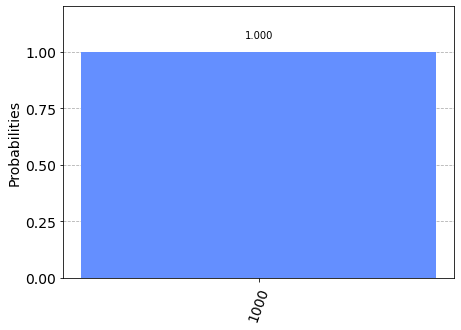

In [5]:
measure_and_plot(qc, shots=1,measure_cntrls= False, cntrl_specifier= 2)

In [6]:
qc.decompose().draw()

┌─────────┐             ░ ┌───────────┐          ┌────────┐»
data-register_0: ─┤ U2(0,π) ├─────────────░─┤ U3(π,0,π) ├──────────┤0       ├»
                  ├─────────┤             ░ ├───────────┤          │        │»
data-register_1: ─┤ U2(0,π) ├─────────────░─┤ U3(π,0,π) ├──────────┤1       ├»
                  ├─────────┤             ░ ├───────────┤          │  Rcccx │»
data-register_2: ─┤ U2(0,π) ├─────────────░─┤ U3(π,0,π) ├──────────┤2       ├»
                  ├─────────┤             ░ ├───────────┤          │        │»
data-register_3: ─┤ U2(0,π) ├─────────────░─┤ U3(π,0,π) ├─■────────┤3       ├»
                 ┌┴─────────┴┐┌─────────┐ ░ └───┬───┬───┘ │U1(π/2) └─┬───┬──┘»
      ancilla_2: ┤ U3(π,0,π) ├┤ U2(0,π) ├─░─────┤ H ├─────■──────────┤ H ├───»
                 └───────────┘└─────────┘ ░     └───┘                └───┘   »
«                                 ┌───────────┐      ┌───────────┐ ░ »
«data-register_0: ────────────────┤0          ├──■───┤ U3(π,0,π) ├─░─»
«                                 │           │  │   ├───────────┤ ░ »
«data-register_1: ────────────────┤1          ├──■───┤ U3(π,0,π) ├─░─»
«                                 │  rcccx_dg │  │   ├───────────┤ ░ »
«data-register_2: ────────────────┤2          ├──■───┤ U3(π,0,π) ├─░─»
«                                 │           │  │   ├───────────┤ ░ »
«data-register_3: ──────■─────────┤3          ├──┼───┤ U3(π,0,π) ├─░─»
«                 ┌───┐ │U1(-π/2) └───┬───┬───┘┌─┴──┐└───────────┘ ░ »
«      ancilla_2: ┤ H ├─■─────────────┤ H ├────┤ Sx ├──────────────░─»
«                 └───┘               └───┘    └────┘              ░ »
«                 ┌───────────┐          ┌────────┐                »
«data-register_0: ┤ U3(π,0,π) ├──────────┤0       ├────────────────»
«                 ├───────────┤          │        │                »
«data-register_1: ┤ U3(π,0,π) ├──────────┤1       ├────────────────»
«                 ├───────────┤          │  Rcccx │                »
«data-register_2: ┤ U3(π,0,π) ├──────────┤2       ├────────────────»
«                 └───────────┘          │        │                »
«data-register_3: ──────────────■────────┤3       ├──────■─────────»
«                     ┌───┐     │U1(π/2) └─┬───┬──┘┌───┐ │U1(-π/2) »
«      ancilla_2: ────┤ H ├─────■──────────┤ H ├───┤ H ├─■─────────»
«                     └───┘                └───┘   └───┘           »
«                 ┌───────────┐      ┌───────────┐ ░ ┌───────────┐          »
«data-register_0: ┤0          ├──■───┤ U3(π,0,π) ├─░─┤ U3(π,0,π) ├──────────»
«                 │           │  │   ├───────────┤ ░ ├───────────┤          »
«data-register_1: ┤1          ├──■───┤ U3(π,0,π) ├─░─┤ U3(π,0,π) ├──────────»
«                 │  rcccx_dg │  │   ├───────────┤ ░ └───────────┘          »
«data-register_2: ┤2          ├──■───┤ U3(π,0,π) ├─░────────────────────────»
«                 │           │  │   └───────────┘ ░ ┌───────────┐          »
«data-register_3: ┤3          ├──┼─────────────────░─┤ U3(π,0,π) ├─■────────»
«                 └───┬───┬───┘┌─┴──┐              ░ └───┬───┬───┘ │U1(π/2) »
«      ancilla_2: ────┤ H ├────┤ Sx ├──────────────░─────┤ H ├─────■────────»
«                     └───┘    └────┘              ░     └───┘              »
«                 ┌────────┐                ┌───────────┐      ┌───────────┐ ░ »
«data-register_0: ┤0       ├────────────────┤0          ├──■───┤ U3(π,0,π) ├─░─»
«                 │        │                │           │  │   ├───────────┤ ░ »
«data-register_1: ┤1       ├────────────────┤1          ├──■───┤ U3(π,0,π) ├─░─»
«                 │  Rcccx │                │  rcccx_dg │  │   └───────────┘ ░ »
«data-register_2: ┤2       ├────────────────┤2          ├──■─────────────────░─»
«                 │        │                │           │  │   ┌───────────┐ ░ »
«data-register_3: ┤3       ├──────■─────────┤3          ├──┼───┤ U3(π,0,π) ├─░─»
«                 └─┬───┬──┘┌───┐ │U1(-π/2) └───┬───┬───┘┌─┴──┐└───────────┘ ░ »
«      ancilla_2: ──┤ 

In [7]:
len(qreg)

4